In [5]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np

In [6]:
import ground_truth as GT
import utils
from RAI_JC_AAI_PA_features_paralel_generation import calculate_features

In [7]:
# SYNTHETIC GRAPH GENERATION

N = 1500                        # graph size   
seed = random.randint(1, 1000)  # random seed

# creating a ground truth graph
G, Comp_G = GT.LFR(n=N)

# df from graph
ground_truth_df = utils.convert_nx_to_dataframe(G, Comp_G)

ground_truth_df0 = ground_truth_df[ground_truth_df['goal'] == 0]
ground_truth_df1 = ground_truth_df[ground_truth_df['goal'] == 1]

n = np.min([len(ground_truth_df0), len(ground_truth_df1)])  # number of sampled edges/non-eges

ground_truth_df = pd.concat([
    ground_truth_df0.sample(int(n/2)), 
    ground_truth_df1.sample(int(n/2))
])

ground_truth_df0 = ground_truth_df[ground_truth_df['goal'] == 0]
ground_truth_df1 = ground_truth_df[ground_truth_df['goal'] == 1]

ground_truth_df.head(5)

,node1,node2,goal
1111215,1358,1369,0
312125,225,1103,0
927149,875,1303,0
322098,233,941,0
979567,966,1243,0


In [8]:
ground_truth_df['goal'].value_counts()

1    1533
0    1533
Name: goal, dtype: int64

In [9]:
# FEATURES

# all edges and non-edges from a complete graph
edge_list = nx.complete_graph(N).edges()

# calculating features
RAI_df, JC_df, AAI_df, PA_df = calculate_features(G, edge_list)

# dataframe with features
features_df = ground_truth_df[['node1', 'node2']]
features_df.head(5)

for df in [RAI_df, JC_df, AAI_df, PA_df]:
    features_df = features_df.merge(df,  how='inner', on=['node1','node2'])

# normalizing
for column_name in ['PA']:
    features_df[column_name] -= features_df[column_name].min()
    features_df[column_name] /= features_df[column_name].max()

# normalized dataframe of features
features_df.head(5)

2021-06-27 20:57:20,800	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


,node1,node2,RAI,JC,AAI,PA
0,1358,1369,0.0,0.0,0.0,0.010582
1,225,1103,0.0,0.0,0.0,0.006349
2,875,1303,0.0,0.0,0.0,0.016931
3,233,941,0.0,0.0,0.0,0.005291
4,966,1243,0.0,0.0,0.0,0.002116


In [10]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [11]:
# CLASSIFIER PARAMETERS

ratio = 0.2  # removing 20% of edges
k = 250      # top K of predicted edges
feature_names = ['RAI', 'JC', 'AAI', 'PA']
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 1]

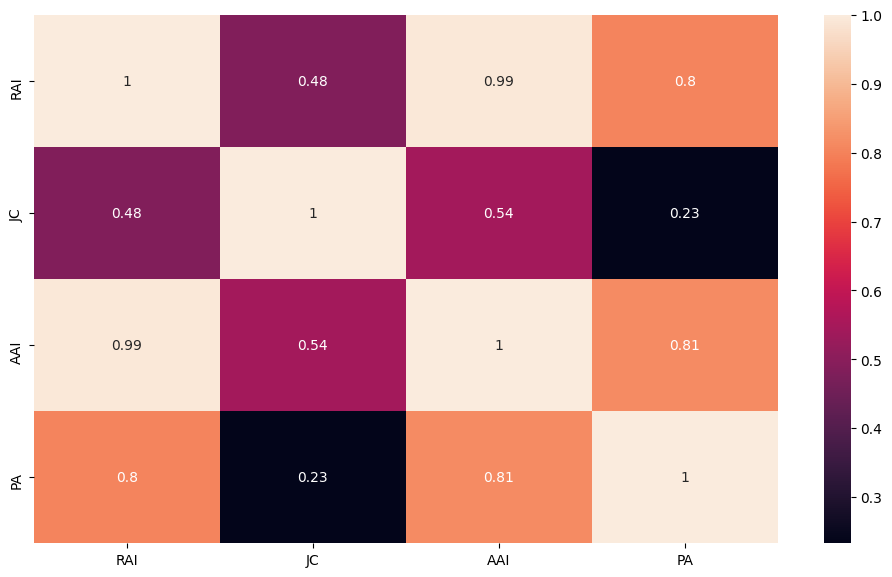

In [12]:
# FEATURE CORRELATION

corrMatrix = features_df[feature_names].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
# TRAIN-TEST SPLITTING

test_df = pd.concat([
    ground_truth_df0.sample(int(len(ground_truth_df0) * ratio)), 
    ground_truth_df1.sample(int(len(ground_truth_df1) * ratio))
])

test_df = test_df[['node1', 'node2']].merge(features_df, how='inner', on=['node1', 'node2'])
train_df = features_df[~features_df.index.isin(test_df.index)]

train_df = train_df.merge(ground_truth_df,  how='inner', on=['node1','node2'])
test_df = test_df.merge(ground_truth_df,  how='inner', on=['node1','node2'])


Accuracy score on top-250 samples: 0.78


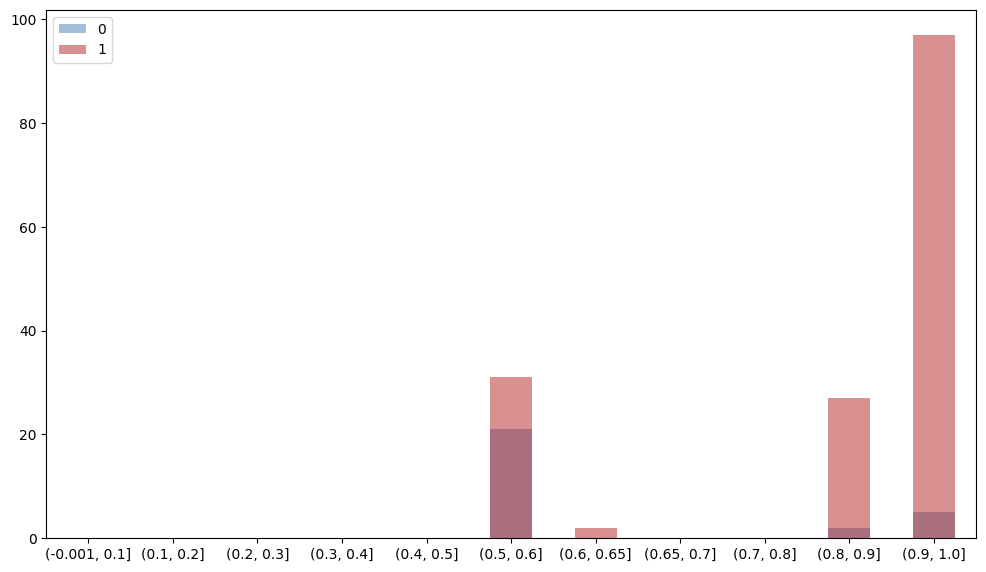

In [14]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(random_state=seed).fit(train_df[feature_names], train_df['goal'])
lr_score, lr_df0, lr_df1, lr_top = utils.top_k(reg, feature_names, k, test_df)

print(f'Accuracy score on top-{k} samples: {lr_score}')
utils.plot_bars(lr_df0, lr_df1, bins)

Accuracy score on top-250 samples: 0.748


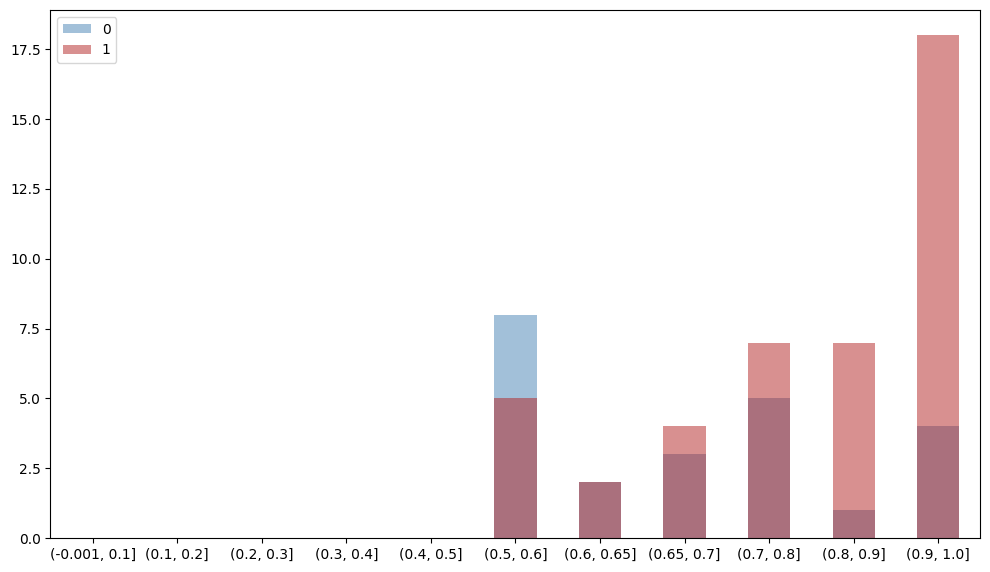

In [15]:
# RANDOM FOREST CLASSIFICATION

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=seed)
forest.fit(train_df[feature_names], train_df['goal'])
fr_score, fr_df0, fr_df1, fr_top = utils.top_k(forest, feature_names, k, test_df)

print(f'Accuracy score on top-{k} samples: {fr_score}')
utils.plot_bars(fr_df0, fr_df1, bins)

Feature importance based on mean decrease in impurity

|     |        0 |
|:----|---------:|
| RAI | 0.246443 |
| JC  | 0.206288 |
| AAI | 0.185361 |
| PA  | 0.361908 | 



Feature importance based on mean accuracy decrease

|     |         0 |
|:----|----------:|
| RAI | 0.0228758 |
| JC  | 0.0196078 |
| AAI | 0.0222222 |
| PA  | 0.0955882 |


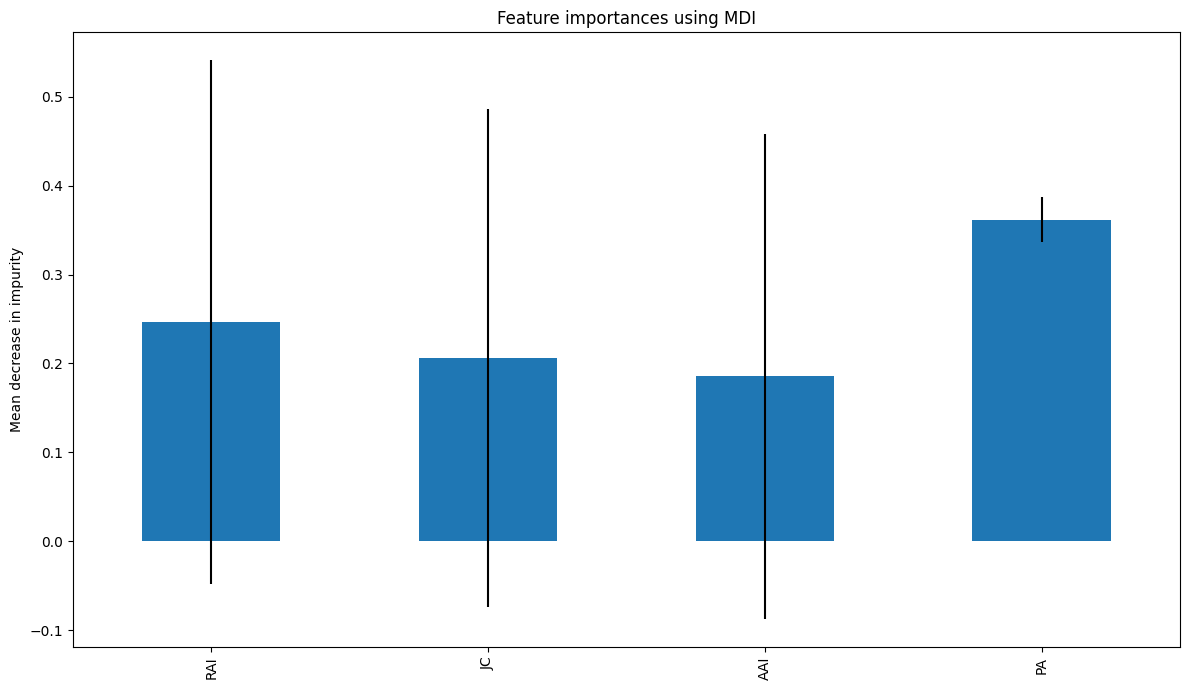

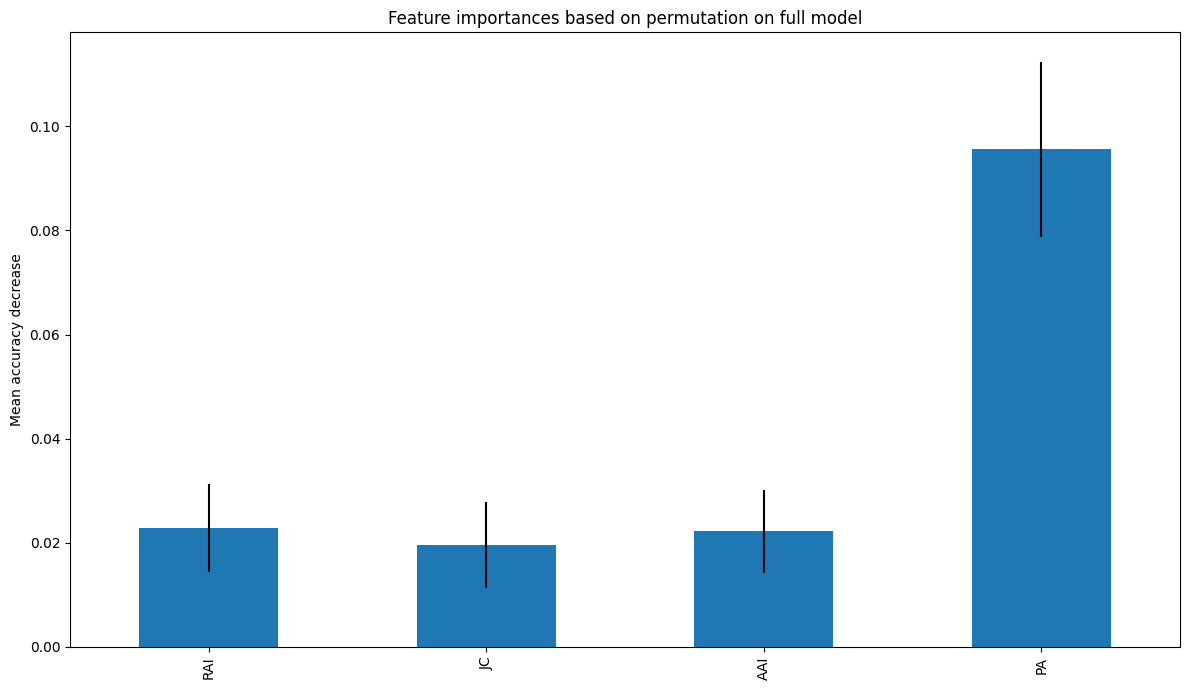

In [16]:
# RANDOM FOREST FEATURE IMPORTANCE

# mean decrease in impurity

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
print('Feature importance based on mean decrease in impurity\n')
print(forest_importances.to_markdown(), '\n\n\n')

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# feature permutation

from sklearn.inspection import permutation_importance

result = permutation_importance(forest, test_df[feature_names],  test_df['goal'], n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
print('Feature importance based on mean accuracy decrease\n')
print(forest_importances.to_markdown())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances based on permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()